# Projet Steganographie texte dans une image rbv

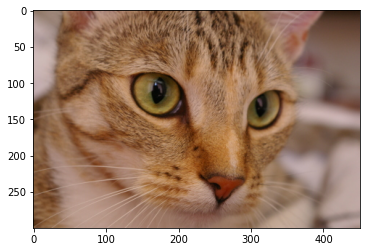

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

img = skimage.data.chelsea()
plt.imshow(img)
plt.show()

## Etape 1 : Transformer chaque caractère en code ASCII puis binaire

In [48]:
message = "Une fois qu'on aura trouvé cette méthode nulle de clé ca sera fini"

In [49]:
def string_to_binaire(message):
    liste_de_binaire = []
    
    # On ajoute un mot-code STOP à la fin du message pour simplifier le décodage
    # Hint : STOP s'écrit en binaire : 01010011, 01010100, 01001111, 01010000
    STOP = ['01010011', '01010100', '01001111', '01010000']
    
    for lettre in message :
        lettre_asci = ord(lettre)
        lettre_binaire = bin(lettre_asci)
        lettre_binaire = lettre_binaire[2:].zfill(8)
        liste_de_binaire.append(lettre_binaire)
        
    return liste_de_binaire + STOP

liste_binaire = string_to_binaire(message)
    
def ligne_binaire(liste):
    chiffres = ""
    for i in liste:
        chiffres += i
        
    return chiffres

message_bin_flat = ligne_binaire(liste_binaire)

On remplace le dernier bit de chaque couleur de chaque pixel par les bits qu'on veut cacher

### A modifier ! Ajouter la clé !

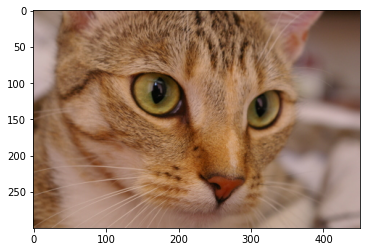

In [50]:
def encoder_image(img, chiffres, lsb, *cle):
    # Tableau de string : va contenir les infos en binaire
    img_bin = np.chararray((img.shape[0], img.shape[1], img.shape[2]), itemsize=8)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                img_bin[i,j,k] = bin(img[i,j,k])[2:].zfill(8)
                
    # mettre au bon format le tableau de string
    img_bin = img_bin.decode("utf-8")
    
    # On flatten l'image pour itérer plus facilement
    img_bin_flat = img_bin.flatten()
    img_encoded_bin = img_bin_flat.copy()
        
    for i in range(len(chiffres)):
        img_encoded_bin[i] = img_encoded_bin[i][:8-lsb] + chiffres[0:lsb]
        chiffres = chiffres[lsb:]
        
    img_encoded_bin = np.reshape(img_encoded_bin, img_bin.shape)
    img_encoded = img.copy()
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                img_encoded[i,j,k] = int(img_encoded_bin[i,j,k],2)
        
    return img_encoded

img_encoded = encoder_image(img, message_bin_flat, 2)
plt.imshow(img_encoded)
plt.show()

## Etape 4 : Decoder le message

In [51]:
cle = np.random.randint(2, size=(img.shape[0], img.shape[1]))
cle *= 2

In [52]:
def deviner_lsb(cle):
    modalites = np.unique(cle)
    return modalites[1]

In [53]:
def find_secret_message_bin(image_bin_flat, lsb):
    i = 1
    message_encoded_bin = []
    bits = ""
    motcode = ""
    STOP = ['01010011', '01010100', '01001111', '01010000']
    
    while(True):
        # On récupère les derniers bits de chaque rvb de chaque pixel
        bits += image_bin_flat[i-1][8-lsb:]

        if (len(bits) == 8):
            message_encoded_bin.append(bits)
            
            # A partir de 4 lettres, on peut penser qu'il y a le mot-code STOP
            # On récupère donc ces 4 dernières lettres et on regarde si c'est STOP
            # Si c'est le cas : on arrête la recherche de binaire
            if(len(message_encoded_bin)>=4):
                maximum = len(message_encoded_bin)
                motcode = message_encoded_bin[maximum-4:maximum]
                
                # On enlève les 4 lettres binaires à la fin du message recupérée
                if(motcode == STOP):
                    message_encoded_bin = message_encoded_bin[:maximum-4]
                    break;
            
            bits = ""
            
        i += 1
    
    return message_encoded_bin

def find_secret_message(image_encoded, cle):
    lsb = deviner_lsb(cle)

    # on la met en binaire
    lig, col, couleur =  image_encoded.shape
    image_bin = np.chararray((lig, col, couleur), itemsize=8)

    for i in range(lig):
        for j in range(col):
            for k in range(couleur):
                image_bin[i,j,k] = bin(image_encoded[i,j,k])[2:].zfill(8)

    image_bin = image_bin.decode("utf-8")
    image_bin_flat = image_bin.flatten()
    
    # Méthode pour trouver le message binaire en utilisant le mot-code STOP
    message_encoded_bin = find_secret_message_bin(image_bin_flat, lsb)
    
    # On transforme tout en ASCII
    message_encoded_ascii = [None]*len(message_encoded_bin)

    for i in range(len(message_encoded_bin)):
        message_encoded_ascii[i] = chr(int(message_encoded_bin[i],2))

    return (''.join(message_encoded_ascii))

secret_message = find_secret_message(img_encoded, cle)
print(secret_message)

Une fois qu'on aura trouvé cette méthode nulle de clé ca sera fini
